# Sample run of visualizing
## Import and magic


In [1]:
%matplotlib inline

import glob
import os
from collections import OrderedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms

## Visual network definition

In [2]:
class Visual(nn.Module):
    """
    Implementation of deconvnet with VGG16 backbone.
    """
    def __init__(self):
        super(Visual, self).__init__()
        
        # Forward pass convolutional network.
        self.convs = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            
            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )
        
        # Backward pass deconvolutional network.
        self.deconvs = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),

            # deconv2
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding=1),
            
            # deconv3
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding=1),
            
            # deconv4
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            
            # deconv5
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding=1)    
        )

        # Kept switches of MaxPool2d, as described in paper.
        self.switches = OrderedDict()

        self._init_weights()
        
    def _init_weights(self):
        """
        Init the weights of conv layers in self.conv and self.deconv
        """
        vgg16_pretrained = models.vgg16(pretrained=True)
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.convs[idx].weight.data = layer.weight.data
                self.convs[idx].bias.data = layer.bias.data
                self.deconvs[30-idx].weight.data = layer.weight.data # from `self.deconvs` idx to `self.convs` idx

    def forward(self, x, layer_idx, filter_idx):
        """Forward of the whole visualizing.

        Forward pass the input x through the convolution network `self.convs` to the specified layer,
        do something on feature map, then backward pass the feature map through the deconvolution
        network `self.deconvs`.
        The basic operation on the feature map is to keep the activation on specified filter while
        change the activations on other filters to zero.
        You can change this operation for other purposes.

        Args:
            x: torch.tensor() of shape [B, C, H, W], input of conv net, namely, the origin image tensor.
            layer_idx: Integer, the layer to visualize.
            filter_idx: Integer, the filter to visualize.

        Returns:
            A torch.tensor() object of the same shape as x.
        """
        # Forward pass.
        # From the beginning pass to the specified layer of the convolution network.
        for idx in range(layer_idx+1):
            # For nn.MaxPool2d layers, keep the max locations in `self.switches` for backward.
            if isinstance(self.convs[idx], nn.MaxPool2d):
                x, loc = self.convs[idx](x) 
                self.switches[idx] = loc
            else:
                x = self.convs[idx](x)
        
        # Operations on feature map.
        # This is just a sample of keeping the activation of filter_id, while change other activations to zeros.

        feature_changed = torch.zeros_like(x)
        sel_map = x[:, filter_idx]
        feature_changed[:, filter_idx] = sel_map
        x = feature_changed
        
        # Backward pass.
        # From the specified layer pass to the end of deconvolution network.
        for idx in range(30-layer_idx, len(self.deconvs)):
            # Use the locations stored in `self.switches` to unpool
            if isinstance(self.deconvs[idx], nn.MaxUnpool2d):
                x = self.deconvs[idx](x, self.switches[30-idx]) # from `self.deconvs` idx to `self.convs` idx
            else:
                x = self.deconvs[idx](x)

        return x

## Utils

In [3]:
def load_img(img_paths):
    """Load images
    Load images from file system with cv2.

    Args:
        img_paths: List of string, the paths of images to load with cv2.

    Returns:
        List of cv2 images, with the same length of img_paths.

    """
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

def img_pre_process(imgs):
    """Image preprocess
    Convert cv2 images to torch.tensor() images.

    Args:
        imgs: List of cv2 images.

    Returns:
        A torch.tensor() object of shape [B, C, H, W]
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    imgs = [transform(img).unsqueeze_(0) for img in imgs]
    img_tensor = torch.cat(imgs, dim=0)
    
    return img_tensor

def img_post_process(img_tensor):
    """Image postprocess
    Convert torch.tensor() images into list of cv2 images.
    1. Convert torch.tensor() to np.array(), and transpose [C, H, W] to [H, W, C].
    2. Scale [0., 1.] into [0, 255].
    3. Convert data format float to np.uint8.
    4. Convert color channels from RGB to BGR (used in cv2 image).

    Args:
        img_tensor, torch.tensor() of shape [B, C, H, W].

    Returns:
        List of cv2 images.
    """
    batch_size = img_tensor.shape[0]
    new_imgs = []
    for batch_idx in range(batch_size):
        new_img = img_tensor.data.numpy()[batch_idx].transpose(1, 2, 0)
        new_img = (new_img - new_img.min()) / (new_img.max()-new_img.min())*255
        new_img = new_img.astype(np.uint8)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
        new_imgs.append(new_img)
    
    return new_imgs

## Main function

In [4]:
def run(img_paths, batch_size, layer_id, filter_id):
    """Run visualizing
    Only for one image, modified from `run.py`
    """
    print('Running on Layer: {}, Filter: {}'.format(layer_id, filter_id))
    
    model = Visual()
    imgs = load_img(img_paths)
    img_tensor = img_pre_process(imgs)
    img_tensor = model(img_tensor, layer_id, filter_id)
    imgs = img_post_process(img_tensor)

    return imgs[0]

## Run samples

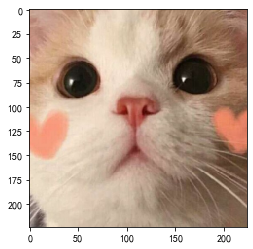

In [5]:
img_paths = ['./sample.jpg']
imgs = load_img(img_paths)
plt.imshow(imgs[0])
plt.show()

Running on Layer: 0, Filter: 14


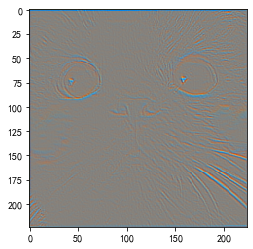

In [6]:
result = run(img_paths, 1, 0, 14)
plt.imshow(result)
plt.show()

Running on Layer: 1, Filter: 20


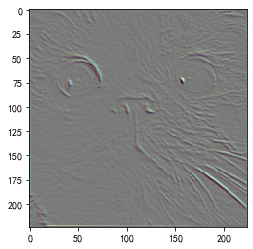

In [7]:
result = run(img_paths, 1, 1, 20)
plt.imshow(result)
plt.show()

Running on Layer: 3, Filter: 20


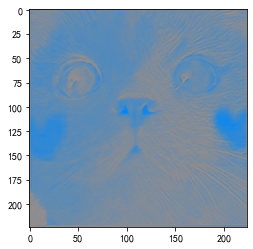

In [8]:
result = run(img_paths, 1, 3, 20)
plt.imshow(result)
plt.show()

Running on Layer: 25, Filter: 10


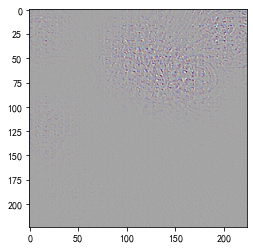

In [9]:
result = run(img_paths, 1, 25, 10)
plt.imshow(result)
plt.show()

Running on Layer: 29, Filter: 500


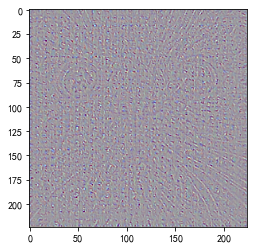

In [10]:
result = run(img_paths, 1, 29, 500)
plt.imshow(result)
plt.show()